In [1]:
import pandas as pd, numpy as np, os
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
output_dir = '/mnt/share/costeffectiveness/results/vivarium_ciff_sam/v7.1.0_full_model_vicious_cyle_diarrhea_remission/ciff_sam/2022_03_08_00_15_24/count_data/'

In [3]:
figname = 'model_7.1.0'

In [4]:
os.listdir(output_dir)

['wasting_transition_count.hdf',
 'diarrhea_transition_count.csv',
 'wasting_transition_count.csv',
 'diarrhea_state_person_time.hdf',
 'wasting_state_person_time.hdf',
 'deaths.csv',
 'diarrhea_state_person_time.csv',
 'wasting_state_person_time.csv',
 'deaths.hdf',
 'disease_transition_count.csv',
 'births.csv',
 'population.csv',
 'stunting_state_person_time.hdf',
 'ylds.csv',
 'ylls.csv',
 'disease_state_person_time.csv',
 'population.hdf',
 'diarrhea_transition_count.hdf',
 'ylls.hdf',
 'ylds.hdf',
 'disease_state_person_time.hdf',
 'births.hdf',
 'disease_transition_count.hdf',
 'stunting_state_person_time.csv']

In [5]:
wasting_pt = pd.read_csv(output_dir +'wasting_state_person_time.csv')
wasting_pt.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,value,diarrhea,sq_lns,mam_treatment,sam_treatment,age
0,0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,covered,covered,early_neonatal
1,1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat1,covered,covered,covered,early_neonatal
2,2,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,uncovered,covered,early_neonatal
3,3,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat1,covered,uncovered,covered,early_neonatal
4,4,female,2022,mild_child_wasting,state_person_time,29,baseline,0.0,cat2,covered,covered,uncovered,early_neonatal


In [6]:
def calculate_child_growth_exposure_prevalence(risk, groupby_cols):
    state_pt = pd.read_csv(output_dir +f'{risk}_state_person_time.csv')
    #state_pt = state_pt.loc[state_pt.scenario=='baseline']
    state_pt = state_pt.groupby(groupby_cols).sum()[['value']].reset_index()
    if risk=='wasting':
        state_pt_exposed = state_pt.loc[state_pt.cause.str.contains('acute_malnutrition')]
        state_pt_exposed['cause'] = 'wasted'
    else:
        state_pt_exposed = state_pt.loc[state_pt.cause.isin(['cat1','cat2'])]
        state_pt_exposed['cause'] = 'stunted'
    state_pt_with_exposed = (pd.concat([state_pt, 
                          state_pt_exposed.groupby(groupby_cols).sum().reset_index()],
                         ignore_index=True)
                .set_index(groupby_cols))
    prev = state_pt_with_exposed / state_pt.groupby([c for c in groupby_cols if c != 'cause']).sum()
    #prev = prev.groupby([c for c in groupby_cols if c != 'input_draw']).describe(percentiles=[0.025,0.975]).sort_index()
    return prev

In [7]:
state_pt = pd.read_csv(output_dir + 'disease_state_person_time.csv')
p = (state_pt.loc[(state_pt.age.isin(['6-11_months','12_to_23_months','2_to_4']))
                 &(state_pt.cause.str.contains('diarr'))]
     .groupby(['input_draw','cause','wasting_state']).sum()[['value']]).reset_index()
p_d = p.loc[p.cause=='diarrheal_diseases'].set_index(['input_draw','wasting_state'])[['value']]
p_d_tot = p_d.groupby('input_draw').sum()
p_d = p_d / p_d_tot
p_s = p.loc[p.cause=='susceptible_to_diarrheal_diseases'].set_index(['input_draw','wasting_state'])[['value']]
p_s_tot = p_s.groupby('input_draw').sum()
p_s = p_s / p_s_tot

pr = p_d/p_s
pr.groupby(['wasting_state']).mean()

,value
wasting_state,


In [8]:
w = calculate_child_growth_exposure_prevalence('wasting', ['scenario','input_draw','sex','age','cause','diarrhea']).reset_index()
pr = (w.loc[w.diarrhea=='cat1'].set_index(['scenario','input_draw','sex','age','cause'])[['value']]
     / w.loc[w.diarrhea=='cat2'].set_index(['scenario','input_draw','sex','age','cause'])[['value']]).reset_index()
pr = pr.loc[pr.age.isin(['6-11_months','12_to_23_months','2_to_4'])].groupby(['scenario','sex','age','cause']).describe(percentiles=[0.025,0.975])
pr = pr[['value']]
pr
# these are a bit more dramatic than I would expect...
# could this be due to a correlation between stunting and wasting??

value  \
                                                                         count   
scenario             sex    age             cause                                
baseline             female 12_to_23_months mild_child_wasting            11.0   
                                            moderate_acute_malnutrition   11.0   
                                            severe_acute_malnutrition     11.0   
                                            susceptible_to_child_wasting  11.0   
                                            wasted                        11.0   
...                                                                        ...   
zinc_supplementation male   6-11_months     mild_child_wasting            11.0   
                                            moderate_acute_malnutrition   11.0   
                                            severe_acute_malnutrition     11.0   
                                            susceptible_to_child_wasting  11.0   
                                            wasted                        11.0   

                                                                                    \
                                                                              mean   
scenario             sex    age             cause                                    
baseline             female 12_to_23_months mild_child_wasting            1.013390   
                                            moderate_acute_malnutrition   1.737821   
                                            severe_acute_malnutrition     1.089566   
                                            susceptible_to_child_wasting  0.916180   
                                            wasted                        1.614350   
...                                                                            ...   
zinc_supplementation male   6-11_months     mild_child_wasting            1.039650   
                                            moderate_acute_malnutrition   1.639351   
                                            severe_acute_malnutrition     1.051951   
                                            susceptible_to_child_wasting  0.904376   
                                            wasted                        1.476315   

                                                                                    \
                                                                               std   
scenario             sex    age             cause                                    
baseline             female 12_to_23_months mild_child_wasting            0.014514   
                                            moderate_acute_malnutrition   0.035695   
                                            severe_acute_malnutrition     0.020032   
                                            susceptible_to_child_wasting  0.007171   
                                            wasted                        0.029515   
...                                                                            ...   
zinc_supplementation male   6-11_months     mild_child_wasting            0.008199   
                                            moderate_acute_malnutrition   0.037975   
                                            severe_acute_malnutrition     0.026967   
                                            susceptible_to_child_wasting  0.006735   
                                            wasted                        0.033809   

                                                                                    \
                                                                               min   
scenario             sex    age             cause                                    
baseline             female 12_to_23_months mild_child_wasting            0.998151   
                                            moderate_acute_malnutrition   1.699883   
                                            severe_acute_malnutrition     1.059346  

these are the expected values
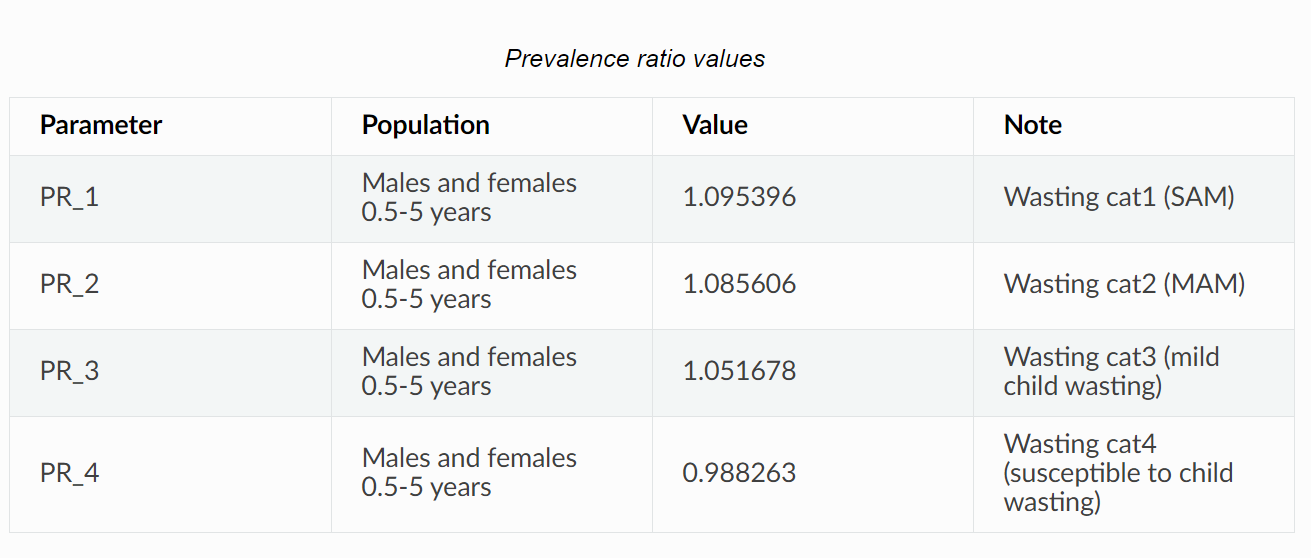

In [9]:
pr.reset_index().loc[(pr.reset_index().scenario=='baseline')
                    &(pr.reset_index().age=='2_to_4')]

# we're mostly looking too high for MAM

scenario     sex     age                         cause value            \
                                                           count      mean   
5   baseline  female  2_to_4            mild_child_wasting  11.0  1.019612   
6   baseline  female  2_to_4   moderate_acute_malnutrition  11.0  1.816104   
7   baseline  female  2_to_4     severe_acute_malnutrition  11.0  1.124679   
8   baseline  female  2_to_4  susceptible_to_child_wasting  11.0  0.923117   
9   baseline  female  2_to_4                        wasted  11.0  1.718453   
20  baseline    male  2_to_4            mild_child_wasting  11.0  1.018866   
21  baseline    male  2_to_4   moderate_acute_malnutrition  11.0  1.764274   
22  baseline    male  2_to_4     severe_acute_malnutrition  11.0  1.110059   
23  baseline    male  2_to_4  susceptible_to_child_wasting  11.0  0.911301   
24  baseline    male  2_to_4                        wasted  11.0  1.646929   

                                                                
         std       min      2.5%       50%     97.5%       max  
5   0.010881  1.000468  1.001435  1.019693  1.035803  1.037052  
6   0.036680  1.747668  1.758093  1.811114  1.882310  1.895474  
7   0.031535  1.095936  1.097002  1.112116  1.190121  1.203910  
8   0.007466  0.908697  0.910580  0.923461  0.934253  0.935728  
9   0.033878  1.650982  1.662982  1.720898  1.778503  1.792401  
20  0.009770  1.004775  1.004949  1.018689  1.035279  1.036710  
21  0.031958  1.727043  1.728296  1.767720  1.822410  1.834323  
22  0.042464  1.031731  1.038999  1.129717  1.157003  1.158487  
23  0.008798  0.893194  0.895825  0.911030  0.924326  0.925987  
24  0.031357  1.600920  1.603052  1.649554  1.700289  1.709936

In [10]:
pr.reset_index().loc[(pr.reset_index().scenario=='baseline')
                    &(pr.reset_index().age=='12_to_23_months')]

# we're mostly looking too high for MAM

scenario     sex              age                         cause value  \
                                                                    count   
0   baseline  female  12_to_23_months            mild_child_wasting  11.0   
1   baseline  female  12_to_23_months   moderate_acute_malnutrition  11.0   
2   baseline  female  12_to_23_months     severe_acute_malnutrition  11.0   
3   baseline  female  12_to_23_months  susceptible_to_child_wasting  11.0   
4   baseline  female  12_to_23_months                        wasted  11.0   
15  baseline    male  12_to_23_months            mild_child_wasting  11.0   
16  baseline    male  12_to_23_months   moderate_acute_malnutrition  11.0   
17  baseline    male  12_to_23_months     severe_acute_malnutrition  11.0   
18  baseline    male  12_to_23_months  susceptible_to_child_wasting  11.0   
19  baseline    male  12_to_23_months                        wasted  11.0   

                                                                          
        mean       std       min      2.5%       50%     97.5%       max  
0   1.013390  0.014514  0.998151  0.998239  1.011332  1.040827  1.044303  
1   1.737821  0.035695  1.699883  1.700020  1.736382  1.795338  1.798505  
2   1.089566  0.020032  1.059346  1.062167  1.087735  1.118365  1.119301  
3   0.916180  0.007171  0.899312  0.901710  0.917642  0.924676  0.925430  
4   1.614350  0.029515  1.582691  1.583858  1.613965  1.661256  1.662291  
15  1.023735  0.012701  1.002995  1.005912  1.021892  1.047317  1.049839  
16  1.687945  0.037448  1.630720  1.634706  1.688327  1.751270  1.760442  
17  1.083202  0.050707  1.024960  1.027766  1.074784  1.168153  1.177077  
18  0.893453  0.009960  0.872962  0.874295  0.895326  0.905586  0.905668  
19  1.544687  0.038721  1.486872  1.491543  1.545567  1.612506  1.623204

In [11]:
# prevalence ratios are exaggerated in the sqlns scenario, which impacts both stunting and wasting
pr.reset_index().loc[(pr.reset_index().age=='12_to_23_months')
                    &(pr.reset_index().scenario.isin(['baseline','sqlns']))].set_index(['sex','cause','scenario'])[['value']].sort_index()

value                      \
                                             count      mean       std   
sex    cause                        scenario                             
female mild_child_wasting           baseline  11.0  1.013390  0.014514   
                                    sqlns     11.0  1.028692  0.014131   
       moderate_acute_malnutrition  baseline  11.0  1.737821  0.035695   
                                    sqlns     11.0  1.802825  0.038102   
       severe_acute_malnutrition    baseline  11.0  1.089566  0.020032   
                                    sqlns     11.0  1.095792  0.027684   
       susceptible_to_child_wasting baseline  11.0  0.916180  0.007171   
                                    sqlns     11.0  0.916045  0.006741   
       wasted                       baseline  11.0  1.614350  0.029515   
                                    sqlns     11.0  1.673145  0.030984   
male   mild_child_wasting           baseline  11.0  1.023735  0.012701   
                                    sqlns     11.0  1.037273  0.015757   
       moderate_acute_malnutrition  baseline  11.0  1.687945  0.037448   
                                    sqlns     11.0  1.746280  0.037752   
       severe_acute_malnutrition    baseline  11.0  1.083202  0.050707   
                                    sqlns     11.0  1.095675  0.051709   
       susceptible_to_child_wasting baseline  11.0  0.893453  0.009960   
                                    sqlns     11.0  0.894574  0.010212   
       wasted                       baseline  11.0  1.544687  0.038721   
                                    sqlns     11.0  1.597526  0.038162   

                                                                            \
                                                   min      2.5%       50%   
sex    cause                        scenario                                 
female mild_child_wasting           baseline  0.998151  0.998239  1.011332   
                                    sqlns     1.014133  1.014589  1.023446   
       moderate_acute_malnutrition  baseline  1.699883  1.700020  1.736382   
                                    sqlns     1.755364  1.756968  1.811558   
       severe_acute_malnutrition    baseline  1.059346  1.062167  1.087735   
                                    sqlns     1.058713  1.059175  1.095069   
       susceptible_to_child_wasting baseline  0.899312  0.901710  0.917642   
                                    sqlns     0.900558  0.902945  0.917874   
       wasted                       baseline  1.582691  1.583858  1.613965   
                                    sqlns     1.633435  1.635157  1.684286   
male   mild_child_wasting           baseline  1.002995  1.005912  1.021892   
                                    sqlns     1.011481  1.015066  1.036835   
       moderate_acute_malnutrition  baseline  1.630720  1.634706  1.688327   
                                    sqlns     1.677447  1.685865  1.743427   
       severe_acute_malnutrition    baseline  1.024960  1.027766  1.074784   
                                    sqlns     1.036109  1.038379  1.090130   
       susceptible_to_child_wasting baseline  0.872962  0.874295  0.895326   
                                    sqlns     0.873806  0.875247  0.896080   
       wasted                       baseline  1.486872  1.491543  1.545567   
                                    sqlns     1.532791  1.539442  1.589495   

                                                                  
                                                 97.5%       max  
sex    cause                        scenario                      
female mild_child_wasting           baseline  1.040827  1.044303  
                                    sqlns     1.056647  1.060974  
       moderate_acute_malnutrition  baseline  1.795338  1.798505  
                                    sqlns     1.855144  1.857792  
       severe_acute_malnutrition    baseline  1.118365  1.119301  
           

In [12]:
def compute_wasting_transition_rate(transition_count_parameter, person_time_state):
    rate = (((wasting_transitions.loc[wasting_transitions.measure==f'{transition_count_parameter}']
           .set_index(['input_draw','age']).drop(columns='measure'))
          / (wasting_person_time.loc[wasting_person_time.cause==f'{person_time_state}']
             .set_index(['input_draw','age']).drop(columns='cause')))
          .groupby(['age']).describe(percentiles=[0.025,0.975]).reset_index())
    rate['source_state'] = person_time_state.replace('_event_count','')
    rate['sink_state'] = transition_count_parameter
    return rate

In [13]:
wasting_transitions = pd.read_csv(output_dir +'wasting_transition_count.csv')
wasting_person_time = pd.read_csv(output_dir +'wasting_state_person_time.csv')

In [14]:
under_six_mo = wasting_transitions.loc[wasting_transitions.age.isin(['early_neonatal',
                                                                    'late_neonatal',
                                                                    '1-5_months'])]
non_zero = under_six_mo.loc[under_six_mo['value']!=0]
non_zero

# cool, no more transitions under six months of age

,Unnamed: 0,sex,year,measure,input_draw,scenario,value,diarrhea,sq_lns,mam_treatment,sam_treatment,age


In [15]:
non_zero.measure.unique()

array([], dtype=object)

In [16]:
transitions = ['mild_child_wasting_to_moderate_acute_malnutrition_event_count']
cause = 'mild_child_wasting'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','sex','age']).describe(percentiles=[0.025,0.975])

# i2 mild to mam

value                                   \
                                count       mean        std        min   
scenario sex    age                                                      
baseline female 12_to_23_months  11.0  34.682328   3.913868  29.987381   
                2_to_4           11.0  40.774744   4.799531  34.204115   
                6-11_months      11.0  54.493091  17.973377  32.708045   
         male   12_to_23_months  11.0  28.437416   3.572451  23.732311   
                2_to_4           11.0  35.785269   3.826458  30.987445   
                6-11_months      11.0  36.404213  10.160437  25.228854   

                                                                             
                                      2.5%        50%      97.5%        max  
scenario sex    age                                                          
baseline female 12_to_23_months  30.299234  33.857042  41.296817  41.301911  
                2_to_4           34.624263  40.406973  48.709220  49.609525  
                6-11_months      33.877794  52.326758  90.228955  95.144475  
         male   12_to_23_months  24.142720  28.076178  35.581241  36.927975  
                2_to_4           31.184202  35.729199  42.361636  43.016941  
                6-11_months      26.317760  33.454610  57.735027  60.788899

In [17]:
transitions = ['susceptible_to_child_wasting_to_mild_child_wasting_event_count']
cause = 'susceptible_to_child_wasting'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','sex','age']).describe(percentiles=[0.025,0.975])


# i3 tmrel to mild

value                                        \
                                count         mean           std        min   
scenario sex    age                                                           
baseline female 12_to_23_months  11.0    65.863386     71.001662  15.829478   
                2_to_4           11.0    53.958846     53.696375  14.850817   
                6-11_months      11.0   199.564462    584.594207   8.498343   
         male   12_to_23_months  11.0   123.739498    191.861429  17.105464   
                2_to_4           11.0    77.345640    100.372781  15.919591   
                6-11_months      11.0  3679.216762  12123.558656   8.918348   

                                                                     \
                                      2.5%        50%         97.5%   
scenario sex    age                                                   
baseline female 12_to_23_months  15.923121  30.899841    200.474284   
                2_to_4           14.973443  28.952639    154.444150   
                6-11_months       9.515149  21.536260   1486.596141   
         male   12_to_23_months  17.609452  34.998530    550.942801   
                2_to_4           16.106526  30.099583    295.181335   
                6-11_months      10.102246  22.745705  30190.328287   

                                               
                                          max  
scenario sex    age                            
baseline female 12_to_23_months    205.282833  
                2_to_4             157.418829  
                6-11_months       1961.650433  
         male   12_to_23_months    633.556365  
                2_to_4             334.468896  
                6-11_months      40233.095675

In [18]:
transitions = ['moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count']
cause = 'moderate_acute_malnutrition'
transition_count = (wasting_transitions.loc[wasting_transitions.measure.isin(transitions)]
                    .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
state_pt = (wasting_person_time.loc[wasting_person_time.cause==cause]
           .groupby(['scenario','input_draw','age','sex','diarrhea']).sum()[['value']])
rate = (transition_count / state_pt).reset_index()
rate = rate.loc[(rate.scenario=='baseline')&(rate.age.isin(['6-11_months','12_to_23_months','2_to_4']))]
rate_d = rate.loc[rate.diarrhea=='cat1'].set_index(['scenario','input_draw','age','sex'])[['value']]
rate_s = rate.loc[rate.diarrhea=='cat2'].set_index(['scenario','input_draw','age','sex'])[['value']]
rr = rate_d / rate_s
rr.groupby(['scenario','age','sex']).describe(percentiles=[0.025,0.975])

# i1 mam to sam

value                                          \
                                count      mean       std       min      2.5%   
scenario age             sex                                                    
baseline 12_to_23_months female  11.0  1.229574  0.115896  1.056950  1.066753   
                         male    11.0  1.335713  0.125858  1.040645  1.084030   
         2_to_4          female  11.0  1.326006  0.151055  1.038799  1.072228   
                         male    11.0  1.310726  0.124685  1.118542  1.131885   
         6-11_months     female  11.0  1.548456  0.193785  1.178780  1.222419   
                         male    11.0  1.520413  0.186563  1.234414  1.271506   

                                                               
                                      50%     97.5%       max  
scenario age             sex                                   
baseline 12_to_23_months female  1.220153  1.423127  1.430980  
                         male    1.356188  1.513513  1.550810  
         2_to_4          female  1.347117  1.531789  1.548204  
                         male    1.328907  1.496905  1.514705  
         6-11_months     female  1.547838  1.809163  1.812184  
                         male    1.448582  1.845711  1.883097